In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from prophet.make_holidays import make_holidays_df
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics


Importing plotly failed. Interactive plots will not work.


In [9]:
# read the data
df = pd.read_csv('bitcoin_price_sentiment_addmean.csv')

# make sure the date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# prepare the dataframe for prophet
prophet_df = df[['date', 'Close']].rename(columns={'date': 'ds', 'Close': 'y'})

# prophet_df = df[['date', 'Close', 'sentiment_scores']].rename(columns={'date': 'ds', 'Close': 'y'})

# add the features to the dataframe
# features = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores']

features = ['sentiment_scores']

# standardize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# add the features to the dataframe
for feature in features:
    prophet_df[feature] = df[feature]

# split the data into train and test
train_df, test_df = train_test_split(prophet_df, test_size=0.2, shuffle=False)

# Define holidays (e.g., US holidays)
# holidays = make_holidays_df(year_list=[2022, 2023, 2024], country='US')


In [10]:
def _calculate_metrics(self, y_true, y_pred):
        """计算评估指标"""
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }

In [ ]:

# param_grid = {
#         'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#         'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#         'seasonality_mode': ['additive', 'multiplicative'],
#         'yearly_seasonality': [True, False],
#         'weekly_seasonality': [True, False],
#         'daily_seasonality': [True, False]
#     }
# results = []
# # 生成所有参数组合
# param_combinations = [dict(zip(param_grid.keys(), v)) 
#                     for v in product(param_grid.values())]

# for params in param_combinations:
#     if params['growth'] == 'logistic':
#         train_df = train_df.copy()
#         train_df['cap'] = self.df['cap']
#         train_df['floor'] = self.df['floor']
#     else:
#         train_df = self.train_df.copy()
    
#     model.fit(train_df)
    
#     # 预测
#     if params['growth'] == 'logistic':
#         future = model.make_future_dataframe(periods=len(self.test_df))
#         future['cap'] = self.df['cap'].iloc[0]
#         future['floor'] = self.df['floor'].iloc[0]
#     else:
#         future = model.make_future_dataframe(periods=len(self.test_df))
#     model = Prophet(params)
#     model.fit(train_df)
    
#     # 预测
#     future = model.make_future_dataframe(periods=len(test_df))
#     forecast = model.predict(future)
    
#     # 评估
#     test_predictions = forecast['yhat'][-len(test_df):]
#     metrics = _calculate_metrics(test_df['y'], test_predictions)
    
#     results.append({
#         'params': params,
#         'metrics': metrics
#     })

# # 按MAPE排序
# results.sort(key=lambda x: x['metrics']['MAPE'])
# best_params = results[0]['params']

15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:44 - cmdstanpy - INFO - Chain [1] done processing


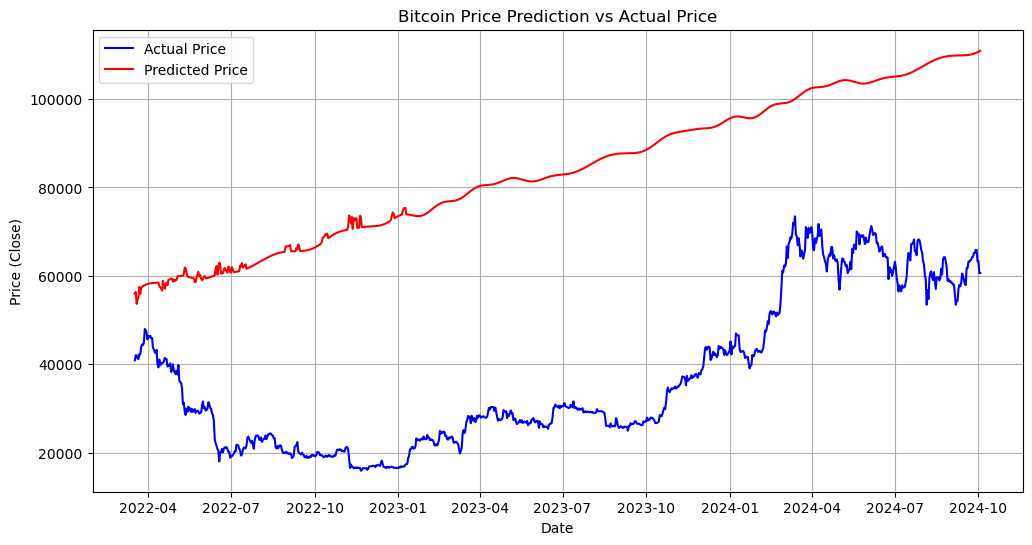

In [11]:
start_time = time.time()

# Initialize the Prophet model with tuned parameters and custom seasonality
model = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=1,
    # holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# create Prophet model
# model = Prophet()
prediction_period = 30

# add regressors
for feature in features:
    model.add_regressor(feature)

# train the model
model.fit(train_df)

# df_cv = cross_validation(model, initial='365.25 days', period='180 days', horizon='60 days')
# df_performance = performance_metrics(df_cv)

future = test_df[['ds', 'sentiment_scores']]

# future = model.make_future_dataframe(periods=prediction_period)
# for feature in features:
#     future[feature] = df[feature].iloc[-1]

forecast = model.predict(future)


end_time = time.time()
runtime = end_time - start_time


# read the prediction result
forecast_filtered = forecast[['ds', 'yhat']]

# merge the prediction result with the actual price
# df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')
df_merged = pd.merge(forecast_filtered, test_df, on='ds', how='left')


# plot the figure
plt.figure(figsize=(12, 6))

# plot the actual price line
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# plot the predicted price line
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# add the legend
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()

In [12]:
# 预测已知的历史数据
historical_forecast = model.predict(prophet_df)


In [15]:

# calculate the metrics
# y_true = prophet_df['y'].values  # 实际值
# y_pred = historical_forecast['yhat'].values  # 预测值
# acual value
y_true = test_df['y'].values  
# predicted value
y_pred = forecast['yhat'].values 

# compute the mean squared error (MSE)
mse = mean_squared_error(y_true, y_pred)

# compute the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# compute the mean absolute error (MAE)
mae = mean_absolute_error(y_true, y_pred)

mask = y_true != 0
# compute the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# compute the coefficient of determination (R^2)
r2 = r2_score(y_true, y_pred)

# print the metrics
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'Runtime: {runtime:.2f} seconds')


MAE: 46848.51483055922
MAPE: 159.97575989240954
Runtime: 1.32 seconds


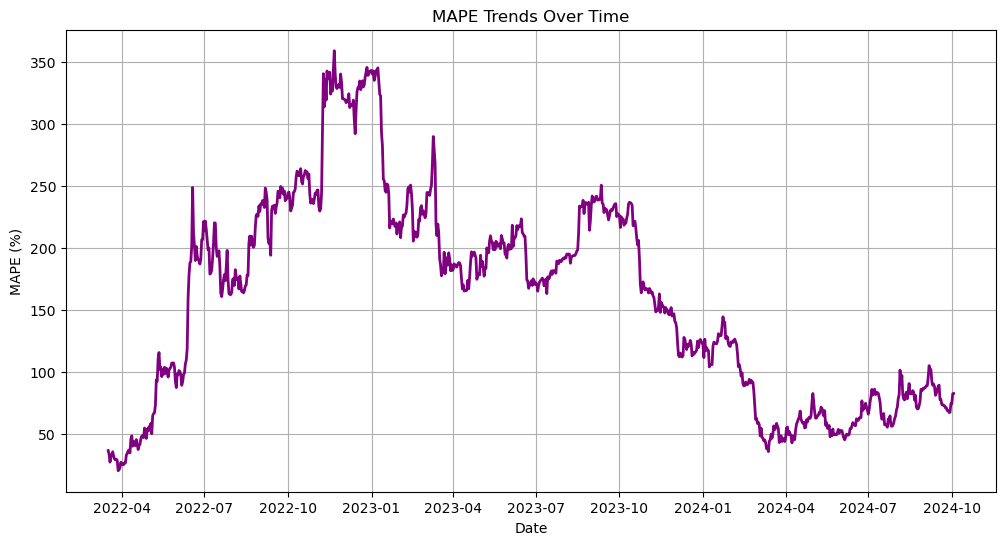

In [16]:
import numpy as np

# Calculate MAPE over time
mape_over_time = 100 * np.abs((y_true - y_pred) / y_true)

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], mape_over_time, label='MAPE', color='purple', linestyle='-', linewidth=2)
plt.title('MAPE Trends Over Time')
plt.xlabel('Date')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

In [20]:
import requests

def get_crypto_compare_data(start_date, end_date, api_key):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 30,  # Set the maximum number of days to retrieve
        'toTs': end_date,
        'api_key': api_key  # Your API key
    }
    response = requests.get(url, params=params)
    data = response.json()

    if 'Data' in data and 'Data' in data['Data']:
        return pd.DataFrame(data['Data']['Data'])
    else:
        print("Error fetching data:", data)
        return None
    
# Assuming you have obtained the API key and set the start and end dates
api_key = 'your_api_key'
start_date = int(pd.Timestamp('2024-10-27').timestamp())
end_date = int(pd.Timestamp('2024-11-30').timestamp())

# Fetch historical price data
btc_data = get_crypto_compare_data(start_date, end_date, api_key)
from datetime import datetime as dt

# 将时间戳列转换为datetime格式，无法解析的时间戳将变为NaT
btc_data['bit_coin_date_time'] = pd.to_datetime(btc_data['time'], unit='s', errors='coerce')
# btc_data.to_csv('bitcoin_date_time_price.csv', index=False)
# 删除包含非法时间戳（NaT）的行
btc_data = btc_data.dropna(subset=['bit_coin_date_time'])
btc_data = btc_data.groupby(btc_data['bit_coin_date_time'].dt.date).tail(1)
btc_data['date'] = btc_data['bit_coin_date_time'].dt.strftime('%Y-%m-%d')
# btc_data = btc_data[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]
# print(btc_data)

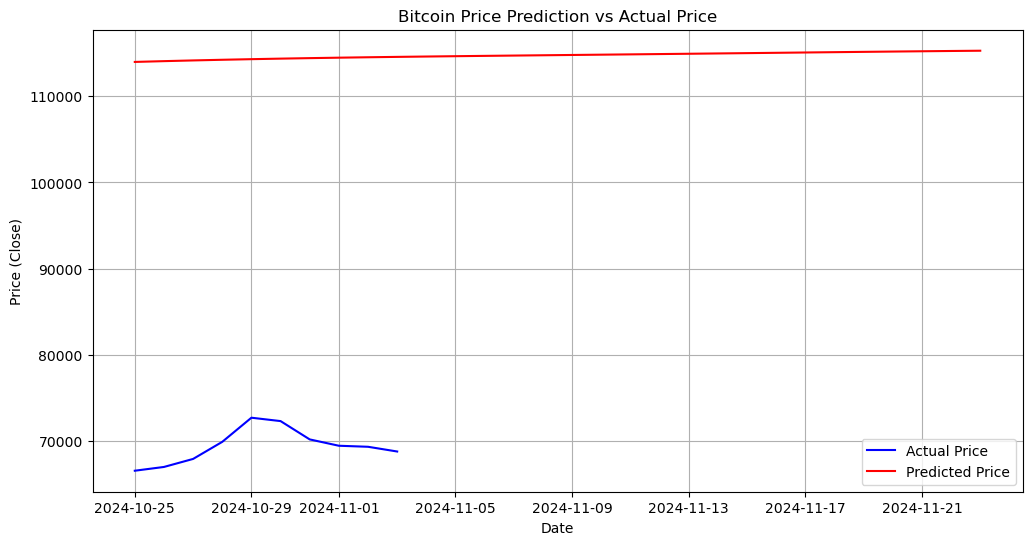

In [22]:
# make sure the date is in datetime format
btc_data['date'] = pd.to_datetime(btc_data['date'])

# prepare the dataframe for prophet
prophet_btc_future = btc_data[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
# print(prophet_btc_future)

start_date = '2024-10-25'  # 预测开始日期
end_date = '2024-11-30'  # 预测截止日期

# 创建未来30天的日期范围
# future_dates = model.make_future_dataframe(periods=prediction_period)
future_dates = pd.date_range(start=start_date, end=end_date)
future_df = pd.DataFrame({'ds': future_dates})
# print(future_dates)
# 为未来日期添加特征值
# 这里我们使用最后一个已知的值，你可能需要根据实际情况调整这个逻辑
for feature in features:
    future_df[feature] = df[feature].iloc[-1]
# 进行预测
forecast = model.predict(future_df)

# read the prediction result
forecast_filtered = forecast[['ds', 'yhat']]
# print(forecast_filtered)

# merge the prediction result with the actual price
# df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')
df_merged = pd.merge(forecast_filtered, prophet_btc_future, on='ds', how='left')

# print(df_merged.head())

df_merged = df_merged[df_merged['ds'] > prophet_df['ds'].max()].head(prediction_period)


# plot the figure
plt.figure(figsize=(12, 6))

# plot the actual price line
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# plot the predicted price line
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# add the legend
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()